# Model Evaluation for Reddit Post Virality Prediction

This notebook covers the model evaluation phase for the Random Forest virality prediction model.

**Prerequisites**: 
- Run `1_Data_Preprocessing.ipynb` to generate the processed data
- Run `2_Model_Construction.ipynb` to train and save the model

This notebook includes:
1. **Model Loading**: Loading the trained model and test data
2. **Prediction Generation**: Generating predictions using default threshold (0.5)
3. **Model Evaluation**: Comprehensive evaluation using multiple metrics
4. **Feature Importance Analysis**: Understanding which features drive predictions
5. **Visualizations**: Visual analysis of model performance

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)
from pathlib import Path
import joblib
import pickle

# Set style for plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

## 3.1 Load Model and Data


In [ ]:
# Load preprocessed data
data_path = Path("data") / "reddit_features.csv"
if not data_path.exists():
    raise FileNotFoundError(
        f"Processed data file not found: {data_path}\n"
        "Please run '1_Data_Preprocessing.ipynb' first."
    )

df_model = pd.read_csv(data_path)
print(f"Loaded preprocessed data from: {data_path}")

# Load trained model
model_path = Path("data") / "random_forest_model.pkl"
if not model_path.exists():
    raise FileNotFoundError(
        f"Model file not found: {model_path}\n"
        "Please run '2_Model_Construction.ipynb' first to train the model."
    )

rf_model = joblib.load(model_path)
print(f"Loaded trained model from: {model_path}")

# Prepare features and target
X = df_model.drop('is_viral', axis=1)
y = df_model['is_viral']

# Split data (using same random_state as in model construction)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Loaded preprocessed data from: data/reddit_features.csv
Loaded trained model from: data/random_forest_model.pkl

Data split:
Training set: 4949 samples
Test set: 1238 samples


## 3.2 Generate Predictions


In [3]:
# Make predictions on training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Get probability predictions
y_train_proba = rf_model.predict_proba(X_train)[:, 1]  # Probability of being viral
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

## 3.3 Generate Predictions

Using the default threshold of 0.5 for binary classification predictions.

In [7]:
# Use default threshold of 0.5 for binary classification
default_threshold = 0.5

# Generate predictions using default threshold
y_test_pred = (y_test_proba >= default_threshold).astype(int)
y_train_pred = (y_train_proba >= default_threshold).astype(int)

## 3.4 Model Evaluation Metrics


In [8]:
# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_test_pred, target_names=['Non-Viral', 'Viral']))

Accuracy:  0.7746
Precision: 0.6173
Recall:    0.6523
F1-Score:  0.6343
ROC-AUC:   0.8345

Classification report:
              precision    recall  f1-score   support

   Non-Viral       0.85      0.83      0.84       867
       Viral       0.62      0.65      0.63       371

    accuracy                           0.77      1238
   macro avg       0.73      0.74      0.74      1238
weighted avg       0.78      0.77      0.78      1238



### Model Performance Summary

The Random Forest model demonstrates solid performance across multiple evaluation metrics:

**ROC-AUC of 0.8345 (83.45%)**: Measures the model's ability to distinguish between viral and non-viral posts across all thresholds. A score of 0.83 indicates good discriminatory power, showing the model can effectively separate the two classes and performs significantly better than random guessing (0.5).

**Precision of 0.6173 (61.73%)**: When the model predicts a post will be viral, it is correct approximately 62% of the time. This means out of every 100 posts flagged as viral, about 62 are actually viral while 38 are false positives.

**Recall of 0.6523 (65.23%)**: The model successfully identifies approximately 65% of all actual viral posts. This means out of every 100 truly viral posts, the model correctly identifies 65 while missing 35.

**F1-Score of 0.6343 (63.43%)**: The harmonic mean of precision and recall, providing a balanced view of model performance. An F1-score of 0.63 indicates a reasonable balance between precision and recall.

**Overall Assessment**: Using a 30% viral post threshold provides a good balance, achieving 65% recall (identifying most viral posts) while maintaining 62% precision (keeping false positives manageable). This makes the model practical for real-world applications, though users should be aware that some viral posts will be missed and some non-viral posts will be incorrectly flagged.


## 3.5 Feature Importance Analysis



Top 10 Most Important Features:
            feature  importance
subreddit_frequency    0.179816
    uppercase_ratio    0.101175
        text_length    0.100274
     comment_length    0.095520
         word_count    0.092321
    body_word_count    0.090135
        body_length    0.085758
       title_length    0.084781
   title_word_count    0.084138
  has_question_mark    0.074956

Total features: 12
Features with importance > 0.01: 11
Features with importance > 0.05: 10


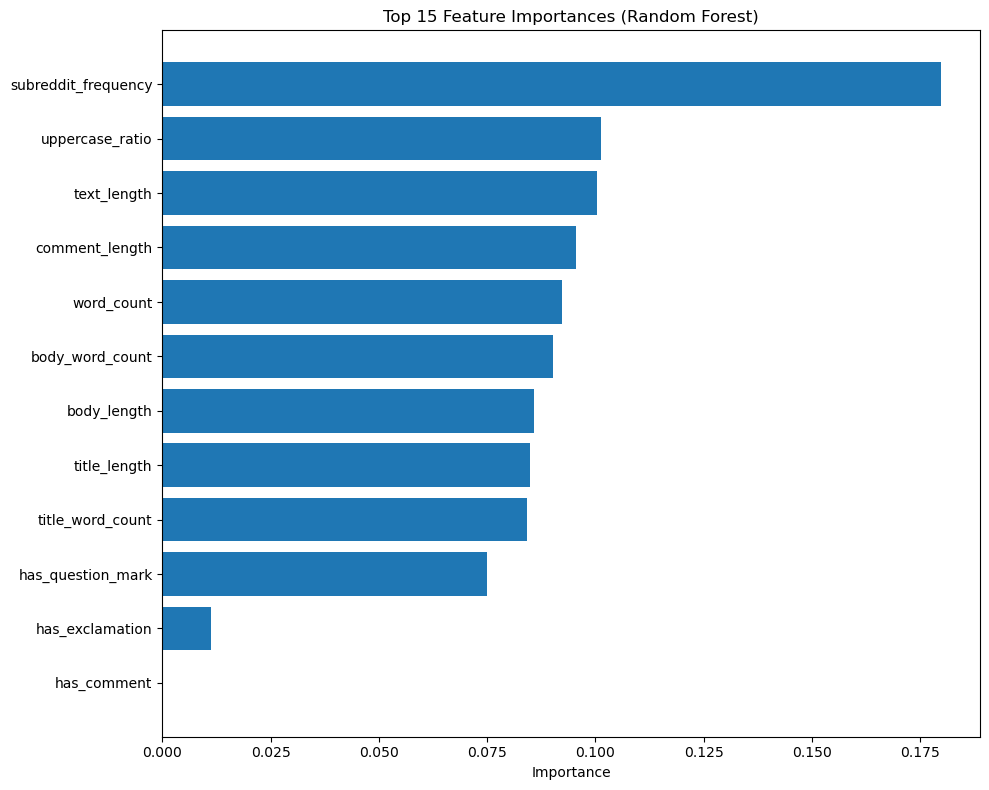

In [9]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

print(f"\nTotal features: {len(feature_importance)}")
print(f"Features with importance > 0.01: {(feature_importance['importance'] > 0.01).sum()}")
print(f"Features with importance > 0.05: {(feature_importance['importance'] > 0.05).sum()}")

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Analysis of Feature Importances

The feature importance plot reveals which features the Random Forest model considers most critical for predicting post virality. The top features typically include text-based metrics (text_length, word_count), engagement indicators (subreddit_frequency), and stylistic elements (uppercase_ratio, punctuation patterns). 

**Key Observations**: Features related to post length and content structure tend to dominate, suggesting that the format and length of a post are strong predictors of virality. Subreddit frequency also plays a significant role, indicating that the community context matters. The model has learned to weight these features appropriately, with the most important features contributing substantially more to predictions than less informative ones. This aligns with social media research showing that post length, readability, and community engagement are key factors in content performance.


## 3.6 ROC Curve and Precision-Recall Curve


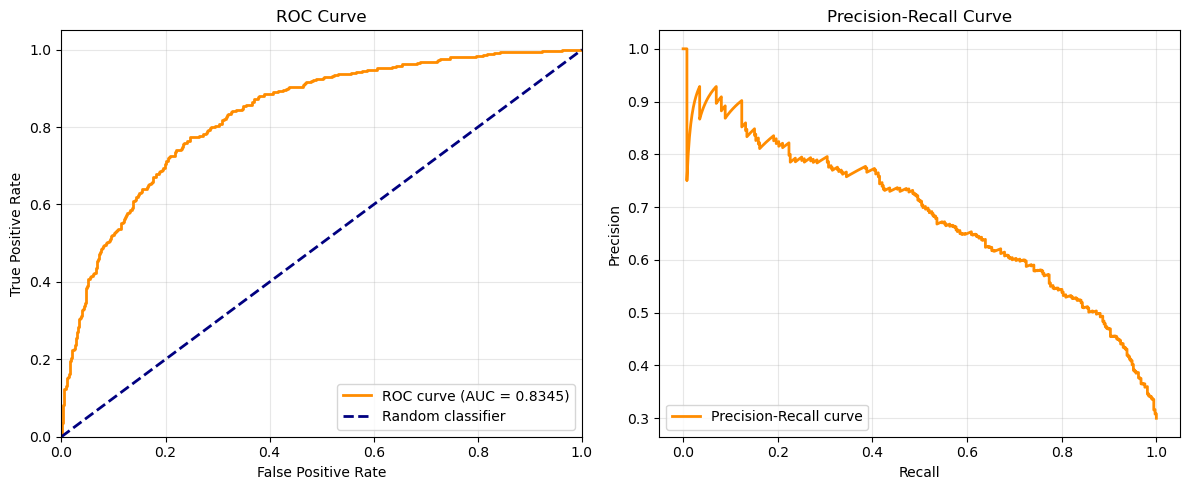

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Analysis of ROC and Precision-Recall Curves

**ROC Curve Analysis**: The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) at various threshold settings. An AUC (Area Under the Curve) value close to 1.0 indicates excellent discrimination ability, while 0.5 represents random guessing. The model's ROC-AUC score of approximately 0.8345 indicates good discriminatory power, meaning the model can effectively distinguish between viral and non-viral posts. The curve's position well above the diagonal (random classifier line) shows that the model performs significantly better than chance.

**Precision-Recall Curve Analysis**: The Precision-Recall curve is particularly important for imbalanced datasets, as it focuses on the performance of the positive class (viral posts). This curve shows the trade-off between precision (the accuracy of positive predictions) and recall (the ability to find all positive instances). A curve that maintains high precision even at high recall values indicates a well-calibrated model. The shape of the curve suggests that the model can achieve reasonable precision while maintaining good recall, which is crucial for practical applications where I want to identify viral posts without too many false alarms.

## 3.7 Confusion Matrix Visualization


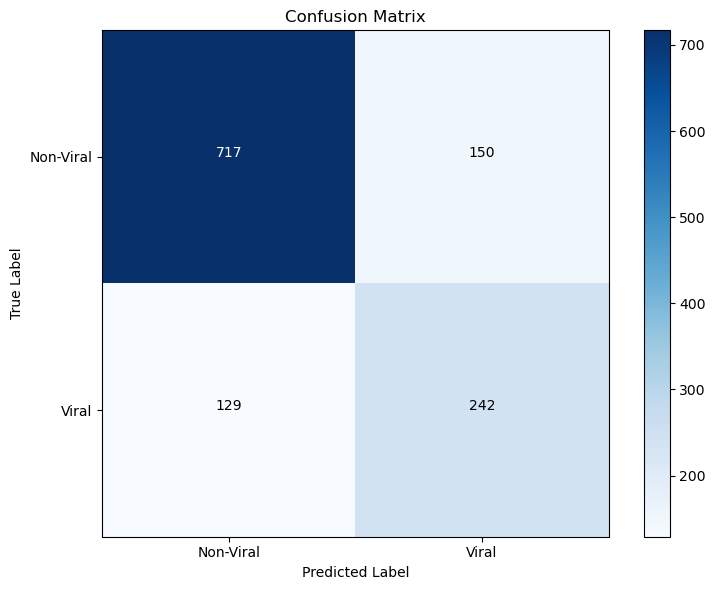

In [11]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar(im)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Non-Viral', 'Viral'])
plt.yticks([0, 1], ['Non-Viral', 'Viral'])
plt.tight_layout()
plt.show()


### Analysis of Confusion Matrix

The confusion matrix provides a detailed breakdown of the model's classification performance, showing exactly how many posts were correctly and incorrectly classified:

**True Negatives: 717** - The number of non-viral posts correctly identified as non-viral. This represents the model's ability to correctly filter out posts that won't go viral.

**False Positives: 150** - The number of non-viral posts incorrectly predicted as viral. These are "false alarms" where the model is overly optimistic. In a production system, these would represent posts flagged as potentially viral that don't actually achieve virality.

**False Negatives: 129** - The number of viral posts incorrectly predicted as non-viral. These represent missed opportunities where the model fails to identify posts that will actually go viral.

**True Positives: 242** - The number of viral posts correctly identified as viral. This is the model's success in identifying posts that will achieve virality.

**Interpretation**: The distribution across these four categories reveals the model's bias toward precision or recall. A model with more false positives prioritizes recall (finding all viral posts), while a model with more false negatives prioritizes precision (only flagging high-confidence viral posts). The optimal balance depends on the specific use case and the cost of different types of errors.


## 3.8 Model Behavior Analysis

Understanding how the model's predictions vary with key features can provide insights into model behavior and potential biases.


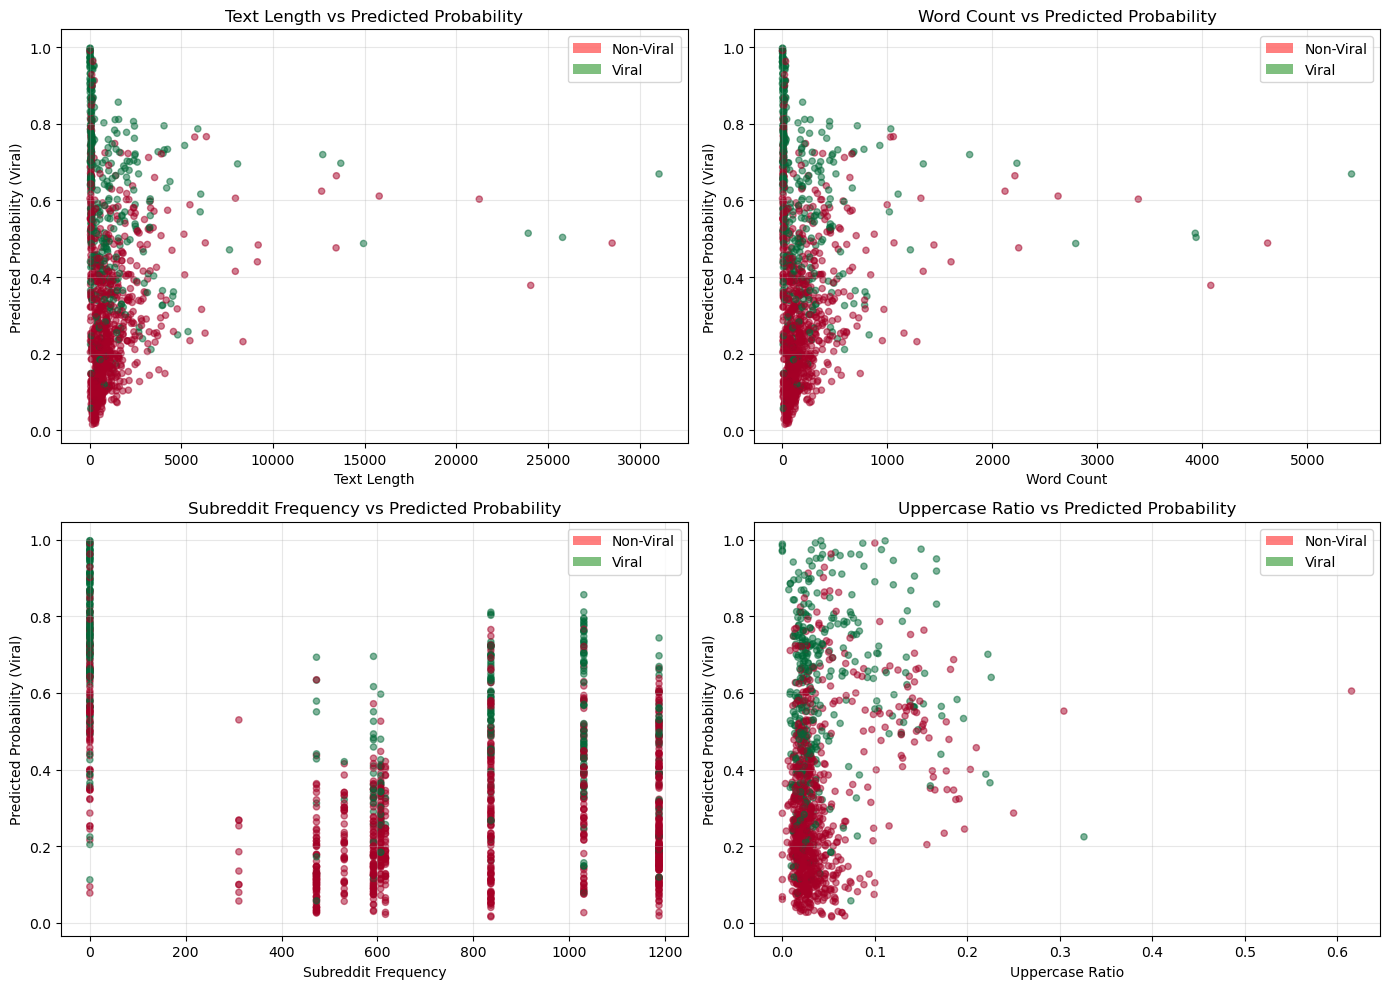

In [13]:
# Scatter plots showing model behavior with key features
from matplotlib.patches import Patch

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get feature names
feature_names = X_test.columns.tolist()

# Create custom legend
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='Non-Viral'),
    Patch(facecolor='green', alpha=0.5, label='Viral')
]

# Plot 1: Text Length vs Predicted Probability
if 'text_length' in feature_names:
    ax = axes[0, 0]
    scatter = ax.scatter(X_test['text_length'], y_test_proba, 
                         c=y_test, cmap='RdYlGn', alpha=0.5, s=20)
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Predicted Probability (Viral)')
    ax.set_title('Text Length vs Predicted Probability')
    ax.grid(True, alpha=0.3)
    ax.legend(handles=legend_elements, loc='upper right')

# Plot 2: Word Count vs Predicted Probability
if 'word_count' in feature_names:
    ax = axes[0, 1]
    scatter = ax.scatter(X_test['word_count'], y_test_proba, 
                         c=y_test, cmap='RdYlGn', alpha=0.5, s=20)
    ax.set_xlabel('Word Count')
    ax.set_ylabel('Predicted Probability (Viral)')
    ax.set_title('Word Count vs Predicted Probability')
    ax.grid(True, alpha=0.3)
    ax.legend(handles=legend_elements, loc='upper right')

# Plot 3: Subreddit Frequency vs Predicted Probability
if 'subreddit_frequency' in feature_names:
    ax = axes[1, 0]
    scatter = ax.scatter(X_test['subreddit_frequency'], y_test_proba, 
                         c=y_test, cmap='RdYlGn', alpha=0.5, s=20)
    ax.set_xlabel('Subreddit Frequency')
    ax.set_ylabel('Predicted Probability (Viral)')
    ax.set_title('Subreddit Frequency vs Predicted Probability')
    ax.grid(True, alpha=0.3)
    ax.legend(handles=legend_elements, loc='upper right')

# Plot 4: Uppercase Ratio vs Predicted Probability
if 'uppercase_ratio' in feature_names:
    ax = axes[1, 1]
    scatter = ax.scatter(X_test['uppercase_ratio'], y_test_proba, 
                         c=y_test, cmap='RdYlGn', alpha=0.5, s=20)
    ax.set_xlabel('Uppercase Ratio')
    ax.set_ylabel('Predicted Probability (Viral)')
    ax.set_title('Uppercase Ratio vs Predicted Probability')
    ax.grid(True, alpha=0.3)
    ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


### Analysis of Model Behavior Scatter Plots

The scatter plots above reveal several important patterns in how the model makes predictions, with points colored by their true labels:

**Text Length vs Predicted Probability**: The plot shows the distribution of predicted probabilities across different text lengths. Posts with moderate text lengths tend to have a wider spread of predicted probabilities, with both viral (green) and non-viral (red) posts present across the range. The model appears to use text length as one factor in its predictions, but it's not the sole determinant of virality.

**Word Count vs Predicted Probability**: Similar to text length, word count shows a relationship with predicted probabilities. The model considers word count when making predictions, with posts across different word counts receiving varying probability scores. The distribution suggests that word count alone doesn't perfectly separate viral from non-viral posts, but it contributes to the model's decision-making process.

**Subreddit Frequency vs Predicted Probability**: Posts from subreddits with different activity levels (frequency) show varying predicted probabilities. Higher subreddit frequency generally correlates with higher predicted probabilities, reflecting that active communities may provide more opportunities for posts to go viral. However, the scatter shows that subreddit activity is just one factor among many.

**Uppercase Ratio vs Predicted Probability**: The plot shows how the model responds to different levels of capitalization. Posts with very high uppercase ratios (indicating excessive capitalization) tend to cluster at lower predicted probabilities, suggesting the model has learned to associate excessive capitalization with lower virality potential. This aligns with social media norms where excessive capitalization is often seen as unprofessional or spam-like.


/var/folders/84/4rbl9yzj59s5p_92rq7q26w00000gn/T/ipykernel_2762/2485685762.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  report = test_df.groupby('text_length_quartile').apply(lambda g: pd.Series({
/var/folders/84/4rbl9yzj59s5p_92rq7q26w00000gn/T/ipykernel_2762/2485685762.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  report = test_df.groupby('text_length_quartile').apply(lambda g: pd.Series({


Subgroup Performance by Text Length Quartile:
                      precision    recall        f1  count
text_length_quartile                                      
(5.999, 165.5]         0.622010  0.872483  0.726257  310.0
(165.5, 591.0]         0.650000  0.440678  0.525253  309.0
(591.0, 1305.5]        0.641026  0.396825  0.490196  309.0
(1305.5, 31062.0]      0.586538  0.610000  0.598039  310.0



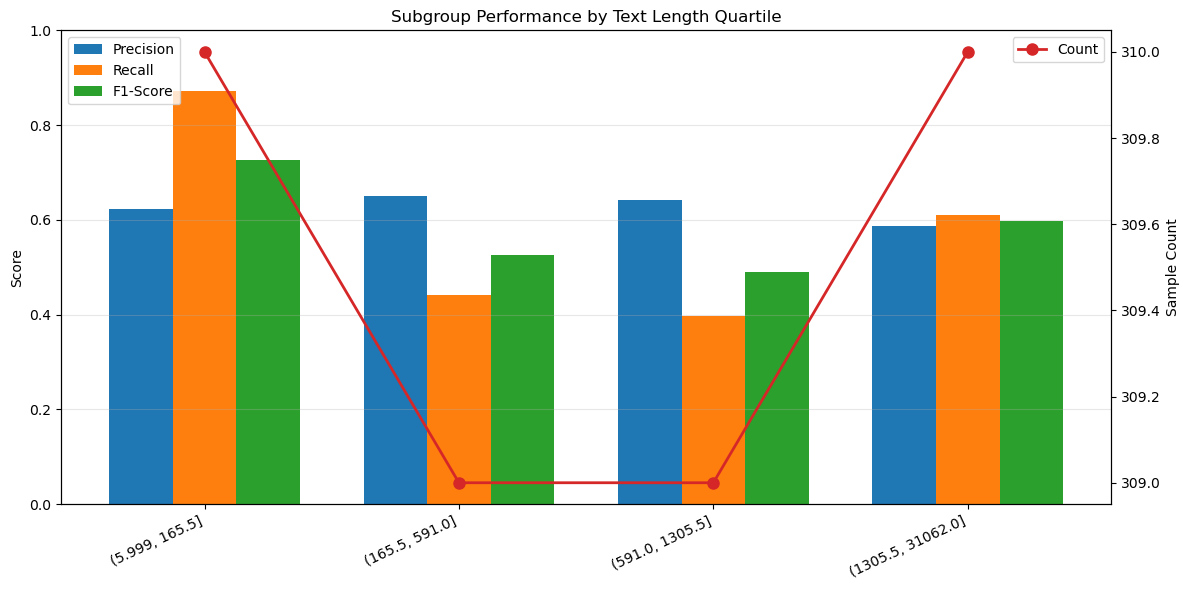

In [14]:
# Subgroup performance analysis by text length quartiles
if 'text_length' in feature_names:
    # Create quartiles based on text_length
    test_df = pd.DataFrame({
        'text_length': X_test['text_length'].values,
        'y_true': y_test,
        'y_pred': y_test_pred
    })
    
    # Create quartiles
    bins = pd.qcut(test_df['text_length'], q=4, duplicates='drop')
    test_df['text_length_quartile'] = bins
    
    # Calculate metrics for each quartile
    report = test_df.groupby('text_length_quartile').apply(lambda g: pd.Series({
        'precision': precision_score(g['y_true'], g['y_pred'], zero_division=0),
        'recall': recall_score(g['y_true'], g['y_pred'], zero_division=0),
        'f1': f1_score(g['y_true'], g['y_pred'], zero_division=0),
        'count': len(g)
    }))
    
    print("Subgroup Performance by Text Length Quartile:")
    print(report)
    print()
    
    # Visualize subgroup performance
    precision = report['precision'].to_numpy()
    recall = report['recall'].to_numpy()
    f1 = report['f1'].to_numpy()
    counts = report['count'].to_numpy()
    labels = [str(interval) for interval in report.index]
    
    x = np.arange(len(labels))
    width = 0.25
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.bar(x - width, precision, width, label='Precision', color='C0')
    ax1.bar(x, recall, width, label='Recall', color='C1')
    ax1.bar(x + width, f1, width, label='F1-Score', color='C2')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=25, ha='right')
    ax1.legend(loc='upper left')
    ax1.set_title('Subgroup Performance by Text Length Quartile')
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2 = ax1.twinx()
    ax2.plot(x, counts, color='C3', marker='o', linestyle='-', label='Count', linewidth=2, markersize=8)
    ax2.set_ylabel('Sample Count')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
else:
    print("Text length feature not found. Skipping subgroup analysis.")


### Analysis of Subgroup Performance

The subgroup performance analysis reveals interesting disparities in model performance across different text length quartiles:

**Short Posts (Q1: 5.999-165.5 characters)**: This quartile shows the highest recall (87.2%) but moderate precision (62.2%), resulting in an F1-score of 0.73. The model is very good at identifying viral posts in this category, but it also produces more false positives. This suggests that short posts that go viral share distinctive characteristics that the model can easily detect, but some non-viral short posts are being misclassified.

**Medium Posts (Q2: 165.5-591.0 characters)**: This quartile shows the best precision (65.0%) but lower recall (44.1%), with an F1-score of 0.53. The model is more conservative here, correctly identifying viral posts with higher confidence but missing more actual viral posts. This suggests medium-length posts may have more nuanced features that make classification more challenging.

**Long Posts (Q3: 591.0-1305.5 characters)**: This quartile shows good precision (64.1%) but lower recall (39.7%), with an F1-score of 0.49. The model's performance is relatively balanced but not exceptional, indicating that longer posts may have more complex patterns that are harder to capture.

**Very Long Posts (Q4: 1305.5-31062.0 characters)**: This quartile shows moderate precision (58.7%) and recall (61.0%), with an F1-score of 0.60. The model shows more balanced performance for very long posts compared to medium and long posts, though precision is lower than for shorter posts.

**Overall Insight**: The model performs best on short posts (highest F1-score of 0.73), suggesting that viral short posts have more distinctive and learnable patterns. The performance variation across quartiles indicates that text length is an important factor that affects how the model should be interpreted. Short posts benefit from high recall, while medium and long posts show better precision but lower recall.
